## Getting more detailed information from Gaussian Processes

- Gaussian processes are commonly used for supervised learning applications
- extremely flexible and powerful models
- models data as being drawn from a set of infinite-dimensional basis functions
- models inherent fluctuations and noise in the data with a covariance or *kernel* function

I used the canonical text by Rasmussen and Williams to familiarise myself with the theory and set to work with using a range of models to try to make predictions of price data.

There are many established codebases for implementing Gaussian Process models but I focused on the `scikit-learn` module and Daniel Foreman-Mackey's `celerite` package

In [2]:
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, RBF, RationalQuadratic, Matern
from sklearn.model_selection import GridSearchCV

import celerite

from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

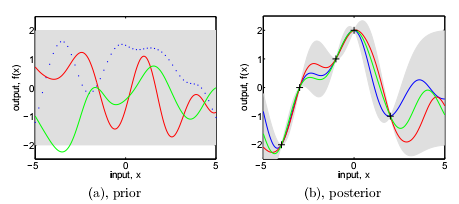

In [3]:
Image("func_view.png")

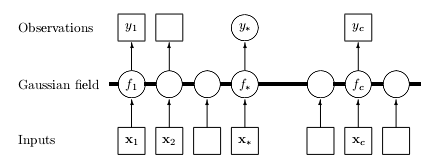

In [4]:
Image("graphical_model.png")

### This time trying to model Ethereum hourly closing prices:

In [10]:
# get some etherium data
eth_hour = pd.read_csv("../dat/bittrex/tickdat/usdt_eth_hour.csv")
datxs = (pd.to_datetime(eth_hour.date) - pd.to_datetime(eth_hour.date)[0]).dt.total_seconds() / 3600

# # let's use the closing price from the last 12 hours to predict
# X = np.zeros((datxs.shape[0] - 12, 12))
# for i in range(12):
#     X[:, i] = datxs[i:-12 + i]
X = np.atleast_2d(datxs).T

y = np.log10(eth_hour.close)
print(eth_hour.shape)
print(X.shape, y.shape)
y.mean()

(1440, 8)
(1440, 1) (1440,)


2.4744005892851151

#### Here I briefly run a Fast Fourier Transform on the data set to see if there are any periodic trends to take into account in the model but I find none of any significance

/home/kilian/.envs/bittrex/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


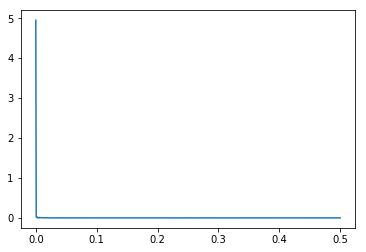

In [11]:
# see are there any strong periodicities

# Number of samplepoints
N = y.shape[0]
# sample spacing
T = X[1,0] - X[0,0]
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()

In [12]:
# first shot with an RBF kernel
gp_kernel = RBF(1.0) + 0.5 * RationalQuadratic(length_scale=1.2, alpha=0.78) + WhiteKernel(1e-3)
gpr = GaussianProcessRegressor(kernel=gp_kernel, normalize_y=True)

In [13]:
# and now fit
gpr.fit(X[:1200, :], y[:1200])

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1) + 0.707**2 * RationalQuadratic(alpha=0.78, length_scale=1.2) + WhiteKernel(noise_level=0.001),
             n_restarts_optimizer=0, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

### Here, I use a very simple Kernel function, consisting only of

- Radial Basis Function - picks up correlated values on some chosen/optimised scale
- An additional term for irregularities that could be inherent to the price
- And a noise term

In [14]:
# make some predictions
y_gpr, y_std = gpr.predict(X, return_std=True)

### This was a very naive model and the result is thus quite poor

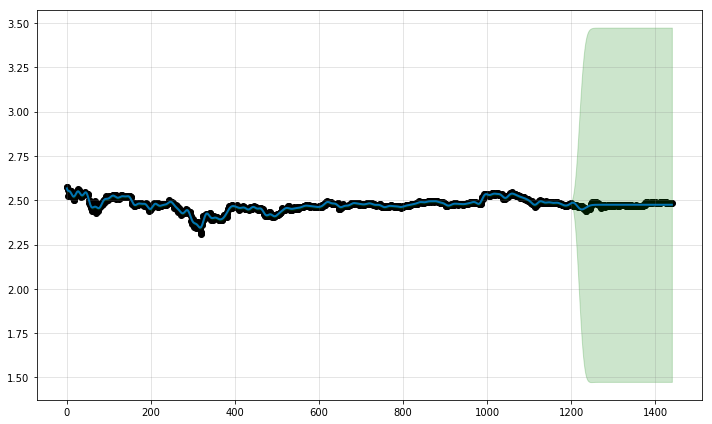

In [15]:
# let's see how it looks with the data
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.scatter(X[:, 0], y, c='k', label='data')
ax.plot(X[:, 0], y_gpr, color='#0072B2', lw=2, label='GPR')
ax.fill_between(X[:, 0], y_gpr - y_std, y_gpr + y_std, color='green', alpha=0.2)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
fig.tight_layout()

### I found that normalising the data prior to modeling, improved the results:

In [16]:
def normalise(y):
    return (y - y.min()) / (y.max() - y.min())

def denormalise(ynorm, ymin, ymax):
    return (ymax - ymin) * ynorm + ymin

### Here I define a more nuanced model:

- Inspired by meteorological models
- Uses RBF again but includes several terms for different time scales
- similarly has several scale terms for irregularities
- one more RBF and white noise terms for noise

In [17]:
# try with normalised target values
yst = normalise(y)

# long-term trends on different scales (RBFs)
# followed by shorter term irregularity trends (RationalQuadratic)
# and some noise terms
gp_kernel = 0.1 * RBF(144) + 0.2 * RBF(48) + 0.4 * RBF(12) +  \
            0.4 * RationalQuadratic(length_scale=6.0, alpha=0.78) + \
            0.4 * RationalQuadratic(length_scale=12.0, alpha=0.78) + \
            0.02 * RBF(.1) + WhiteKernel(1e-1)
gpr = GaussianProcessRegressor(kernel=gp_kernel)

gpr.fit(X[1000:1200, :], yst[1000:1200])

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=0.316**2 * RBF(length_scale=144) + 0.447**2 * RBF(length_scale=48) + 0.632**2 * RBF(length_scale=12) + 0.632**2 * RationalQuadratic(alpha=0.78, length_scale=6) + 0.632**2 * RationalQuadratic(alpha=0.78, length_scale=12) + 0.141**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

### I ran this model with a shorter training data set 

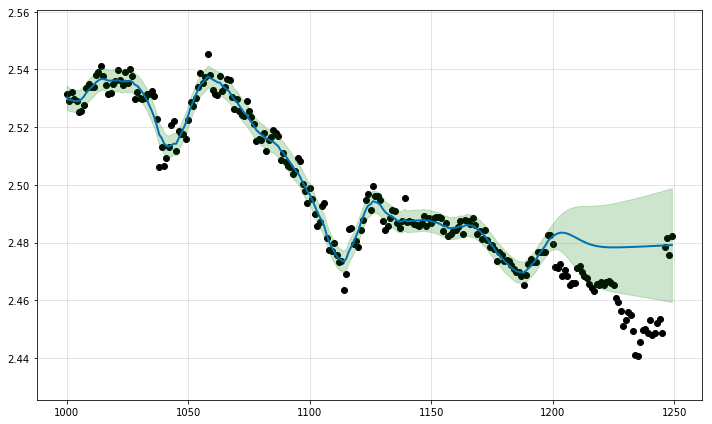

In [18]:
y_gpr, y_std = gpr.predict(X[1000:1250, :], return_std=True)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.scatter(X[1000:1250, 0], y[1000:1250], c='k', label='data')
ax.plot(X[1000:1250, 0], denormalise(y_gpr, y.min(), y.max()), color='#0072B2', lw=2, label='GPR')
ax.fill_between(X[1000:1250, 0],
                denormalise(y_gpr - y_std, y.min(), y.max()),
                denormalise(y_gpr + y_std, y.min(), y.max()),
                color='green', alpha=0.2)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
fig.tight_layout()

In [19]:
# try at a different point in time
start = 800
stop = 1000
npredict = 50
predstop = stop + npredict

gpr.fit(X[start:stop, :], yst[start:stop])

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=0.316**2 * RBF(length_scale=144) + 0.447**2 * RBF(length_scale=48) + 0.632**2 * RBF(length_scale=12) + 0.632**2 * RationalQuadratic(alpha=0.78, length_scale=6) + 0.632**2 * RationalQuadratic(alpha=0.78, length_scale=12) + 0.141**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

### I run it at several points in the data set to account for the different kinds of regimes the price could be in

### I want to find a model that is robust to many kinds of price trends

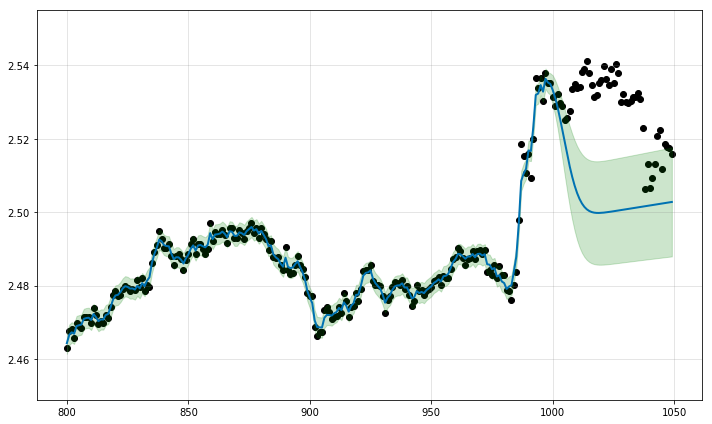

In [20]:
y_gpr, y_std = gpr.predict(X[start:predstop, :], return_std=True)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.scatter(X[start:predstop, 0], y[start:predstop], c='k', label='data')
ax.plot(X[start:predstop, 0], denormalise(y_gpr, y.min(), y.max()), color='#0072B2', lw=2, label='GPR')
ax.fill_between(X[start:predstop, 0],
                denormalise(y_gpr - y_std, y.min(), y.max()),
                denormalise(y_gpr + y_std, y.min(), y.max()),
                color='green', alpha=0.2)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
fig.tight_layout()

In [21]:
# try at a different point in time
start = 600
stop = 800
npredict = 50
predstop = stop + npredict

gpr.fit(X[start:stop, :], yst[start:stop])

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=0.316**2 * RBF(length_scale=144) + 0.447**2 * RBF(length_scale=48) + 0.632**2 * RBF(length_scale=12) + 0.632**2 * RationalQuadratic(alpha=0.78, length_scale=6) + 0.632**2 * RationalQuadratic(alpha=0.78, length_scale=12) + 0.141**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

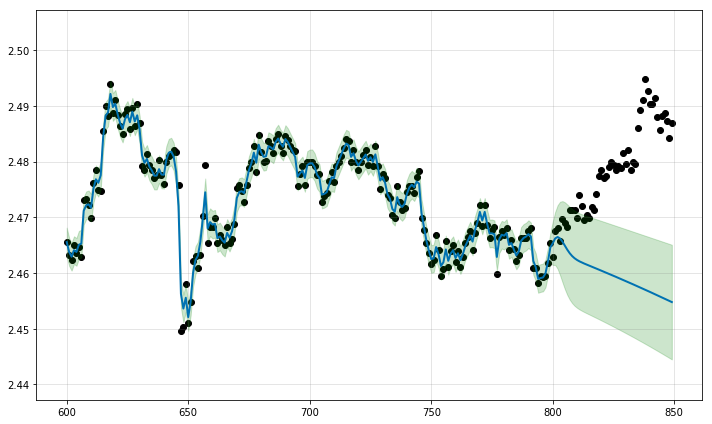

In [22]:
y_gpr, y_std = gpr.predict(X[start:predstop, :], return_std=True)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.scatter(X[start:predstop, 0], y[start:predstop], c='k', label='data')
ax.plot(X[start:predstop, 0], denormalise(y_gpr, y.min(), y.max()), color='#0072B2', lw=2, label='GPR')
ax.fill_between(X[start:predstop, 0],
                denormalise(y_gpr - y_std, y.min(), y.max()),
                denormalise(y_gpr + y_std, y.min(), y.max()),
                color='green', alpha=0.2)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
fig.tight_layout()

In [23]:
start = 1200
stop = 1400
npredict = 40
predstop = stop + npredict

gpr.fit(X[start:stop, :], yst[start:stop])

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=0.316**2 * RBF(length_scale=144) + 0.447**2 * RBF(length_scale=48) + 0.632**2 * RBF(length_scale=12) + 0.632**2 * RationalQuadratic(alpha=0.78, length_scale=6) + 0.632**2 * RationalQuadratic(alpha=0.78, length_scale=12) + 0.141**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

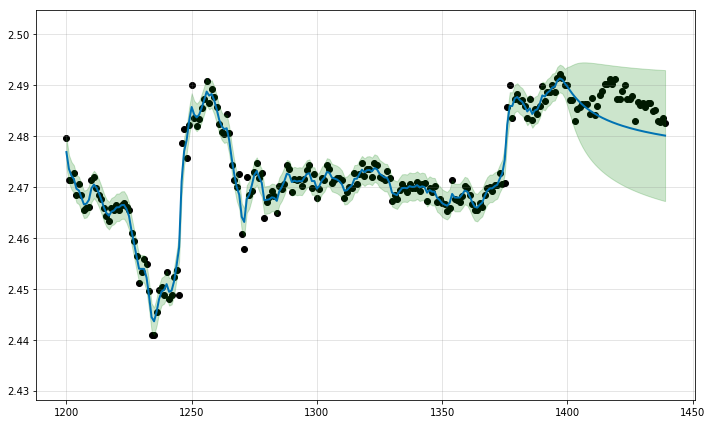

In [24]:
y_gpr, y_std = gpr.predict(X[start:predstop, :], return_std=True)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.scatter(X[start:predstop, 0], y[start:predstop], c='k', label='data')
ax.plot(X[start:predstop, 0], denormalise(y_gpr, y.min(), y.max()), color='#0072B2', lw=2, label='GPR')
ax.fill_between(X[start:predstop, 0],
                denormalise(y_gpr - y_std, y.min(), y.max()),
                denormalise(y_gpr + y_std, y.min(), y.max()),
                color='green', alpha=0.2)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
fig.tight_layout()

In [25]:
start = 0
stop = 1400
npredict = 40
predstop = stop + npredict

gpr.fit(X[start:stop, :], yst[start:stop])

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=0.316**2 * RBF(length_scale=144) + 0.447**2 * RBF(length_scale=48) + 0.632**2 * RBF(length_scale=12) + 0.632**2 * RationalQuadratic(alpha=0.78, length_scale=6) + 0.632**2 * RationalQuadratic(alpha=0.78, length_scale=12) + 0.141**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

### Now I run the model over the full data set and try to predict only the final 40 price values

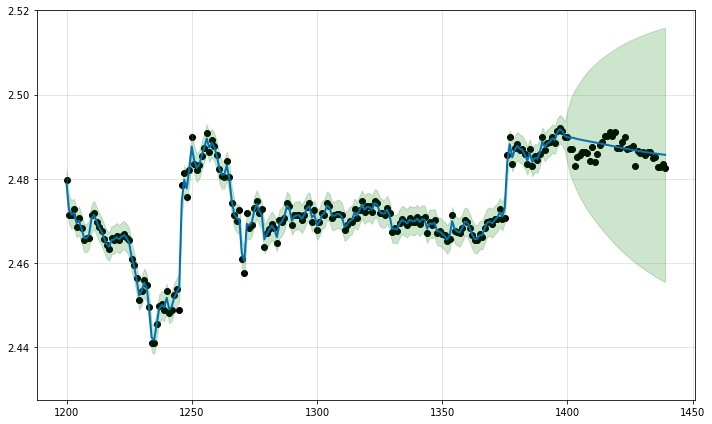

In [26]:
plotstart = 1200

y_gpr, y_std = gpr.predict(X[plotstart:predstop, :], return_std=True)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.scatter(X[plotstart:predstop, 0], y[plotstart:predstop], c='k', label='data')
ax.plot(X[plotstart:predstop, 0], denormalise(y_gpr, y.min(), y.max()), color='#0072B2', lw=2, label='GPR')
ax.fill_between(X[plotstart:predstop, 0],
                denormalise(y_gpr - y_std, y.min(), y.max()),
                denormalise(y_gpr + y_std, y.min(), y.max()),
                color='green', alpha=0.2)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
fig.tight_layout()

In [182]:
gpr = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=8)
gpr.fit(X[start:stop, :], yst[start:stop])

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=0.316**2 * RBF(length_scale=144) + 0.447**2 * RBF(length_scale=48) + 0.632**2 * RBF(length_scale=12) + 0.632**2 * RationalQuadratic(alpha=0.78, length_scale=6) + 0.632**2 * RationalQuadratic(alpha=0.78, length_scale=12) + 0.141**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1),
             n_restarts_optimizer=8, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [31]:
def predict_and_plot(X, y, gpr, plotstart, predstop):
    
    y_gpr, y_std = gpr.predict(X[plotstart:predstop, :], return_std=True)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.scatter(X[plotstart:predstop, 0], y[plotstart:predstop], c='k', label='data')
    ax.plot(X[plotstart:predstop, 0], denormalise(y_gpr, y.min(), y.max()), color='#0072B2', lw=2, label='GPR')
    ax.fill_between(X[plotstart:predstop, 0],
                    denormalise(y_gpr - y_std, y.min(), y.max()),
                    denormalise(y_gpr + y_std, y.min(), y.max()),
                    color='green', alpha=0.2)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    fig.tight_layout()

### By running the optimiser multiple times, I can get an improvement on the uncertainties in the prediction

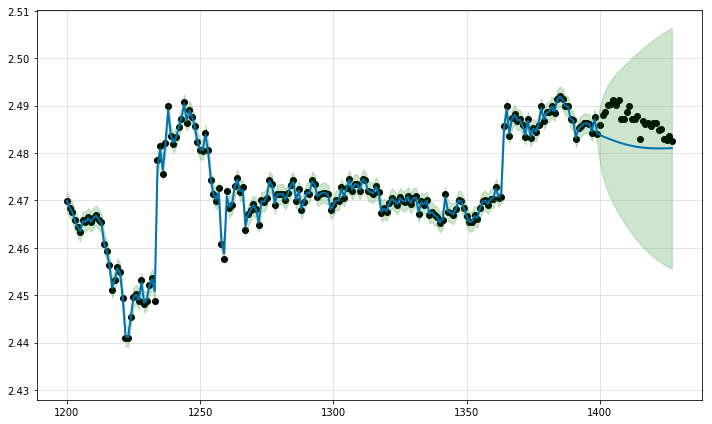

In [184]:
plotstart = 1200

predict_and_plot(X, y, gpr, plotstart, predstop)

In [28]:
# now to try with a different kernel - Matern

# Try with some different length scale Ohrstein-Uhlenbeck style processes
# Include a trend term for longer term trends
# and some noise
gp_kernel = 0.4 * RBF(144) + 0.1 * RBF(72) + 0.1 * RBF(24) + 0.1 * RBF(12) +  \
            0.2 * Matern(6.0, nu=0.5) + 0.2 * Matern(2.0, nu=0.5) + \
            0.1 * RBF(.1) + WhiteKernel(1e-1)
            
gpr = GaussianProcessRegressor(kernel=gp_kernel)

## Now to try again with a new kernel

- Reading a little in the literature of financial time series modeling, I found a paper "A Novel Approach to Forecasting Financial Volatility with Gaussian Process Envelopes" by Rizvi et al. at Oxford ML Researhc group
- They found Gaussian Processes could get significantly better volatility estimates than the usual generalized autoregressive conditional heteroskedasticity (GARCH) models used in time series analysis
- In particular, they found their best results when using a Matérn kernel
- Matérn kernel is a generalisation of the Ornstein-Uhlenbeck process, which is commonly enocuntered in stochastic processes in physics and finance
- Here I use the RBF to model long term trends again and model the stochasticity with Matérn kernels, along with some added noise terms

In [29]:
start = 1200
stop = 1405
npredict = 35
predstop = stop + npredict

gpr.fit(X[start:stop, :], yst[start:stop])

/home/kilian/.envs/bittrex/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=0.632**2 * RBF(length_scale=144) + 0.316**2 * RBF(length_scale=72) + 0.316**2 * RBF(length_scale=24) + 0.316**2 * RBF(length_scale=12) + 0.447**2 * Matern(length_scale=6, nu=0.5) + 0.447**2 * Matern(length_scale=2, nu=0.5) + 0.316**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

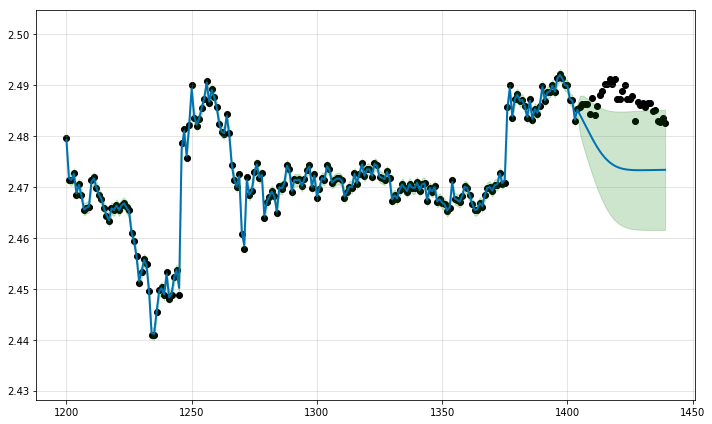

In [32]:
plotstart = start

predict_and_plot(X, y, gpr, plotstart, predstop)

In [42]:
# try at a different point in time
start = 500
stop = 700
npredict = 50
predstop = stop + npredict

gpr.fit(X[start:stop, :], yst[start:stop])

/home/kilian/.envs/bittrex/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=0.632**2 * RBF(length_scale=144) + 0.316**2 * RBF(length_scale=72) + 0.316**2 * RBF(length_scale=24) + 0.316**2 * RBF(length_scale=12) + 0.447**2 * Matern(length_scale=6, nu=0.5) + 0.447**2 * Matern(length_scale=2, nu=0.5) + 0.316**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

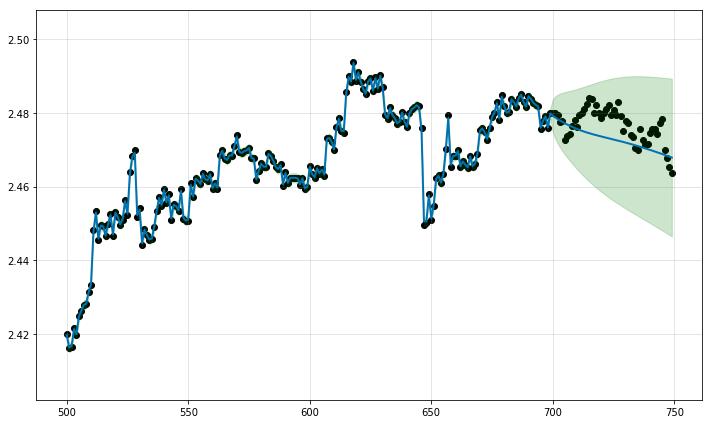

In [43]:
plotstart = start

predict_and_plot(X, y, gpr, plotstart, predstop)

In [35]:
# try at a different point in time
start = 500
stop = 1000
npredict = 50
predstop = stop + npredict

gpr.fit(X[start:stop, :], yst[start:stop])

/home/kilian/.envs/bittrex/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=0.632**2 * RBF(length_scale=144) + 0.316**2 * RBF(length_scale=72) + 0.316**2 * RBF(length_scale=24) + 0.316**2 * RBF(length_scale=12) + 0.447**2 * Matern(length_scale=6, nu=0.5) + 0.447**2 * Matern(length_scale=2, nu=0.5) + 0.316**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

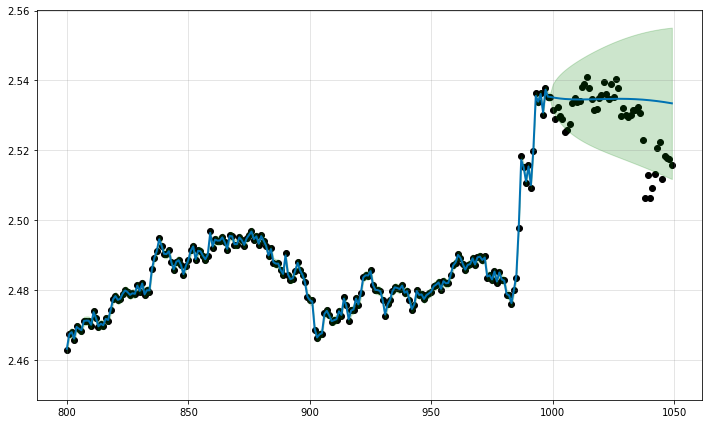

In [37]:
plotstart = 800

predict_and_plot(X, y, gpr, plotstart, predstop)

## Another thing with Facebook Prophet didn't implement was the addition of more explanatory variables

### Here I am adding bitcoin price over the period to help predict ethereum prices

In [38]:
# Now to add bitcoin data into the mix
btc_hour = pd.read_csv("../dat/bittrex/tickdat/usdt_btc_hour.csv")
btcys = np.log10(btc_hour.close)

# combining data
X = np.zeros((datxs.shape[0], 2))
X[:, 0] = datxs
X[:, 1] = btcys

y = np.log10(eth_hour.close)
print(eth_hour.shape)
print(X.shape, y.shape)
y.mean()

(1440, 8)
(1440, 2) (1440,)


2.4744005892851151

In [44]:
start = 500
stop = 700
npredict = 50
predstop = stop + npredict

gpr.fit(X[start:stop, :], yst[start:stop])

/home/kilian/.envs/bittrex/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=0.632**2 * RBF(length_scale=144) + 0.316**2 * RBF(length_scale=72) + 0.316**2 * RBF(length_scale=24) + 0.316**2 * RBF(length_scale=12) + 0.447**2 * Matern(length_scale=6, nu=0.5) + 0.447**2 * Matern(length_scale=2, nu=0.5) + 0.316**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

## Here are the results for the same Matern kernel model using more information

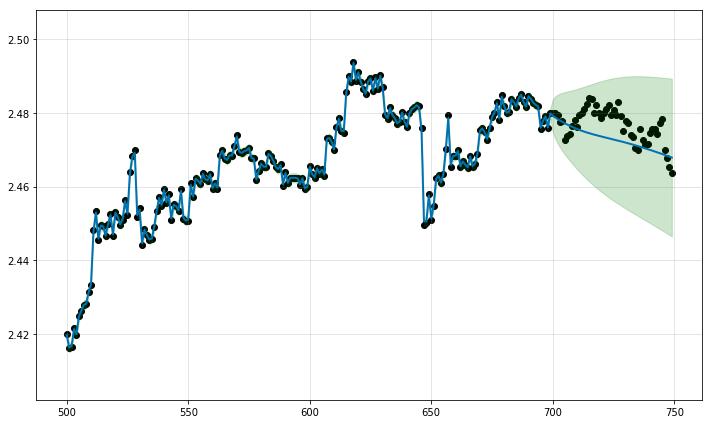

In [45]:
plotstart = start

predict_and_plot(X, y, gpr, plotstart, predstop)

In [46]:
start = 600
stop = 800
npredict = 50
predstop = stop + npredict

gpr.fit(X[start:stop, :], yst[start:stop])

/home/kilian/.envs/bittrex/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=0.632**2 * RBF(length_scale=144) + 0.316**2 * RBF(length_scale=72) + 0.316**2 * RBF(length_scale=24) + 0.316**2 * RBF(length_scale=12) + 0.447**2 * Matern(length_scale=6, nu=0.5) + 0.447**2 * Matern(length_scale=2, nu=0.5) + 0.316**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

### It even does better than one of the trickier scenarios before

#### (Though this is somewhat contrived...)

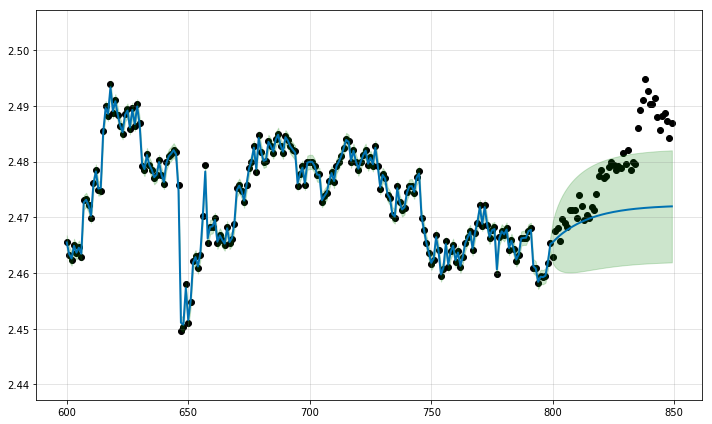

In [49]:
plotstart = start

predict_and_plot(X, y, gpr, plotstart, predstop)